In [218]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [220]:
OUT_DIM=6

In [221]:
path = Path("./activations")

In [222]:
img_files = get_files(path/"img"); img_files

(#359882) [Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_783154_3660743_1420_09102014_1.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1012920_310814938_1420_01122016_27.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_822006_4778600_1420_19062014_3.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_299.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_821707_4770044_1420_19062014_4.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_288.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019716_311062360_1420_17012017_15.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1062700_312268503_1420_21072017_6.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1053618_311977154_1420_07062017_248.pt'),Path('activations/img/val/agravo_em_recurso_extraordinario/ARE_1019823_3

In [223]:
text_files = get_files(path/"text"); text_files

(#326037) [Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1075473_312738372_1420_14092017_6.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1054017_311988070_1420_08062017_7.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1082106_312930948_1420_10102017_15.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1087577_313124642_1420_26102017_6.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1000611_310414607_1420_01102016_14.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1075473_312738372_1420_14092017_7.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_1062700_312268503_1420_21072017_4.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_941848_308456398_1420_14012016_3.npy'),Path('activations/text/val/agravo_em_recurso_extraordinario/ARE_941656_308447674_1420_12012016_11.npy'),Path('activations/text/val/agravo_em_recurso_extraor

In [224]:
text_set = set([t.with_suffix("").name for t in text_files])

In [225]:
img_set = set([t.with_suffix("").name for t in img_files])

In [226]:
len(text_set), len(img_set)

(326037, 359882)

In [227]:
img_and_text = text_set.intersection(text_set, img_set); len(img_and_text)

326033

In [228]:
just_img = img_set - text_set; len(just_img)

33849

In [229]:
just_text = text_set - img_set; len(just_text)

4

In [231]:
data = img_files

In [232]:
for file in text_files:
    if file.with_suffix("").name in just_text:
         data.append(file)

In [233]:
len(data)

359886

In [234]:
img_shape = torch.load(data[0]).shape

In [235]:
text_shape = np.load(data[-1]).shape

In [236]:
img_shape, text_shape

(torch.Size([4096]), (3840,))

In [237]:
class GetActs(Transform):
    def encodes(self, x):
        img_file = text_file = None
        img_none = text_none = False
        if x.with_suffix("").name in img_and_text:
            img_file = x
            text_file = Path(x.as_posix().replace("img", "text").replace("pt", "npy"))
        elif x.with_suffix("").name in just_img:
            img_file=x
        elif x.with_suffix("").name in just_text:
            text_file=x
        if img_file is None:
            img_act = torch.zeros(img_shape)
            img_none=True
        else:
            img_act = torch.load(img_file)
        if text_file is None:
            text_act = torch.zeros(text_shape)
            text_none = True
        else:
            text_act = tensor(np.load(text_file))
        return (img_act, text_act, img_none, text_none)

In [239]:
tfms = [[GetActs()], [parent_label, Categorize()]]
splits = GrandparentSplitter(valid_name='val')(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders()

In [240]:
dls.train_ds, dls.valid_ds

((#158308) [((tensor([1.0705, 2.5618, 1.5041,  ..., 0.6216, 0.0583, 0.2009]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, True), TensorCategory(1)),((tensor([0.4848, 2.4331, 1.3183,  ..., 0.4955, 0.6567, 0.3695]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, True), TensorCategory(1)),((tensor([1.7524, 1.5423, 1.3229,  ..., 0.1082, 0.5275, 0.3602]), tensor([0.0000, 0.0000, 0.1854,  ..., 0.0000, 0.0000, 0.0000]), False, False), TensorCategory(1)),((tensor([0.8225, 1.9279, 1.7849,  ..., 0.1336, 0.2967, 0.2964]), tensor([0.0444, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), False, False), TensorCategory(1)),((tensor([1.2731, 1.4753, 2.8595,  ..., 0.1491, 0.1504, 0.1222]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, True), TensorCategory(1)),((tensor([1.8722, 1.9171, 3.0970,  ..., 0.5567, 0.3478, 0.4769]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), False, True), TensorCategory(1)),((tensor([0.7557, 0.9525, 1.6604,  ..., 0.1216, 0.3352, 0.2508]), tensor([0.6888, 1.2101, 0.0938,  ..., 

In [241]:
b = dls.one_batch(); b

((tensor([[0.7258, 2.2842, 1.1495,  ..., 0.4943, 0.2448, 0.4559],
          [3.9682, 4.4083, 5.9929,  ..., 0.0064, 1.0457, 1.9220],
          [0.7044, 1.7413, 1.3487,  ..., 0.2609, 0.1685, 0.1987],
          ...,
          [1.2259, 1.0644, 1.6343,  ..., 0.3172, 0.3849, 0.0763],
          [0.4785, 2.0461, 1.5653,  ..., 0.1081, 0.3039, 0.3872],
          [0.5970, 1.6778, 1.3574,  ..., 0.3253, 0.4117, 0.2772]],
         device='cuda:0'),
  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3160, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3964, 0.0704, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
         device='cuda:0'),
  tensor([False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, Fals

In [242]:
b[0][0].shape, b[0][1].shape

(torch.Size([64, 4096]), torch.Size([64, 3840]))

In [303]:
class ImgTextFusion(Module):
    def __init__(self, head, embs_for_none=True, img_emb_dim=4096, text_emb_dim=3840):
        self.head = head.cuda()
        self.embs_for_none = embs_for_none
        if embs_for_none:
            self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
            self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
            self.index= tensor(0).cuda()
    
    def forward(self, x):
        img_act, text_act, img_none, text_none = x
        if self.embs_for_none:
            img_act[img_none] = self.img_none_emb(self.index)
            text_act[text_none] = self.text_none_emb(self.index)
        return self.head(torch.cat([img_act, text_act], axis=-1))

In [304]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [305]:
head = create_head(4096 + 3840, OUT_DIM)

In [306]:
model = ImgTextFusion(head)

In [307]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [308]:
fscore = F1Score(average='macro')

In [317]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [318]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 512             4,063,232  True      
________________________________________________________________
ReLU                 64 x 512             0          False     
________________________________________________________________
BatchNorm1d          64 x 512             1,024      True      
________________________________________________________________
Dropout              64 x 512             0          False     
________________________________________________________________
Linear               64 x 6               3,072      True      
__________________________

In [320]:
learn.validate()

(#3) [1.780272364616394,0.1119547188282013,0.05780499452619731]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.05754399299621582)

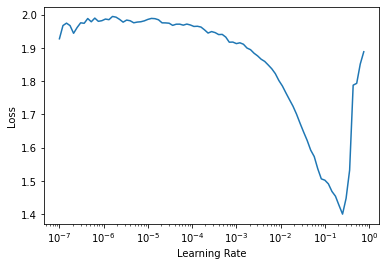

In [264]:
learn.lr_find()

In [321]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.156895,0.292673,0.941911,0.725074,29:36
1,0.318428,1.201178,0.937260,0.583699,23:12
2,0.301540,61.136528,0.928328,0.560453,10:39
3,0.233729,20.332190,0.934231,0.603734,12:55
4,0.236815,0.497308,0.923037,0.694410,08:44
5,0.175361,2.344356,0.896745,0.624413,09:05
6,0.122372,11.672071,0.932726,0.546704,08:21
7,0.090470,0.654125,0.939872,0.722263,08:19
8,0.088848,2.647726,0.938765,0.744009,07:36
9,0.073090,1.100814,0.938212,0.708762,08:06


Better model found at epoch 0 with f1_score value: 0.725074400379516.


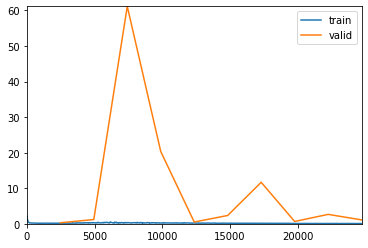

Better model found at epoch 8 with f1_score value: 0.7440088203861196.


In [323]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [325]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [326]:
model = ImgTextFusion(head)

In [327]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [328]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.2089296132326126)

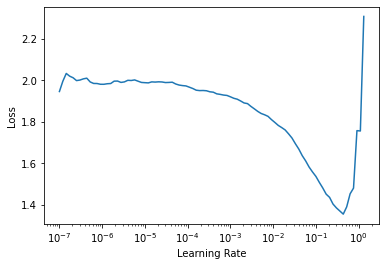

In [329]:
learn.lr_find()

In [330]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.118076,0.293594,0.937688,0.703868,09:25
1,0.162370,0.363445,0.934920,0.535164,08:54
2,0.165360,0.322928,0.941018,0.664880,08:14
3,0.140249,0.340284,0.937270,0.731723,07:42
4,0.141849,0.320091,0.940746,0.704346,07:50
5,0.119744,0.328166,0.942678,0.731926,08:02


Better model found at epoch 0 with f1_score value: 0.7038682571851839.


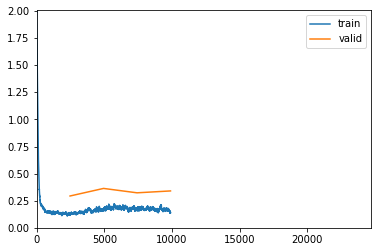

Better model found at epoch 3 with f1_score value: 0.7317225459776453.


In [ ]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [325]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [326]:
model = ImgTextFusion(head, embs_for_none=False)

In [327]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [328]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.2089296132326126)

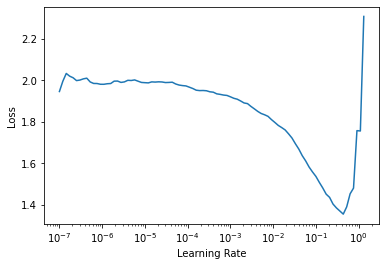

In [329]:
learn.lr_find()

In [330]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128_zeros'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.118076,0.293594,0.937688,0.703868,09:25
1,0.162370,0.363445,0.934920,0.535164,08:54


Better model found at epoch 0 with f1_score value: 0.7038682571851839.


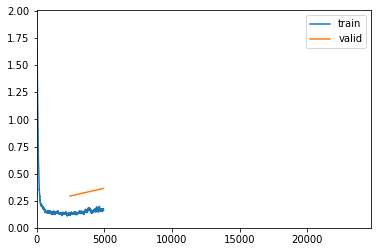

In [ ]:
learn.fit_one_cycle(10, lr_max=5e-2)